In [1]:
import os
os.chdir("..")

In [2]:
from src.data.data_process import DataReg
import polars as pl
import requests
import bambi as bmb
import geopandas as gpd
from pysal.lib import weights
from shapely import wkt
import pandas as pd
import arviz as az
import matplotlib.dates as mdates
import numpy as np
import causalpy as cp
import matplotlib.pyplot as plt
dr = DataReg()

In [3]:
df_qcew = dr.base_data().with_columns(
    treatment=pl.when(pl.col("year") >= 2023).then(True).otherwise(False)
)
df_dp03 = dr.pull_dp03()
df_dp03 = df_dp03.with_columns(qtr=1)
pr_zips = gpd.GeoDataFrame(dr.make_spatial_table().df())
pr_zips["geometry"] = pr_zips["geometry"].apply(wkt.loads)
pr_zips = pr_zips.set_geometry("geometry")
pr_zips["zipcode"] = pr_zips["zipcode"].astype(str)

df = df_qcew.join(df_dp03, on=["zipcode","year", "qtr"], how="left")
df = pr_zips.join(
    df.to_pandas().set_index("zipcode"), on="zipcode", how="inner", validate="1:m"
        ).reset_index(drop=True)
df = df[df["year"] >= 2012].sort_values(by=["zipcode","year","qtr"]).reset_index(drop=True)
df

zipcode                                           geometry  year  qtr  \
0      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    1   
1      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    2   
2      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    3   
3      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    4   
4      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2013    1   
...      ...                                                ...   ...  ...   
6564   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    2   
6565   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    3   
6566   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    4   
6567   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2024    1   
6568   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2024    2   

      mw_industry  total_employment  min_wage   k_index  treatment  \
0     3085.513141          7.919753    3770.0  1.221839      False   
1     3067.451828          8.014749    3770.0  1.229033      False   
2     3136.436473          7.972222    3770.0  1.202001      False   
3     3276.314539          8.053857    3770.0  1.150683      False   
4     2989.406736          8.238095    3770.0  1.261120      False   
...           ...               ...       ...       ...        ...   
6564  7951.577594         37.829060    4420.0  0.555865       True   
6565  7829.340318         37.754274    4420.0  0.564543       True   
6566  8371.587625         37.030120    4420.0  0.527976       True   
6567  8163.801974         35.916667    5460.0  0.668806       True   
6568  8639.551295         35.847390    5460.0  0.631977       True   

      total_population  ...  inc_less_10k  inc_10k_15k  inc_15k_25k  \
0              14443.0  ...        2351.0        585.0        836.0   
1                  NaN  ...           NaN          NaN          NaN   
2                  NaN  ...           NaN          NaN          NaN   
3                  NaN  ...           NaN          NaN          NaN   
4              14440.0  ...        2659.0        613.0        845.0   
...                ...  ...           ...          ...          ...   
6564               NaN  ...           NaN          NaN          NaN   
6565               NaN  ...           NaN          NaN          NaN   
6566               NaN  ...           NaN          NaN          NaN   
6567               NaN  ...           NaN          NaN          NaN   
6568               NaN  ...           NaN          NaN          NaN   

      inc_25k_35k  inc_35k_50k  inc_50k_75k  inc_75k_100k  inc_100k_150k  \
0           607.0        556.0        329.0         156.0           19.0   
1             NaN          NaN          NaN           NaN            NaN   
2             NaN          NaN          NaN           NaN            NaN   
3             NaN          NaN          NaN           NaN            NaN   
4           563.0        488.0        366.0         140.0           60.0   
...           ...          ...          ...           ...            ...   
6564          NaN          NaN          NaN           NaN            NaN   
6565          NaN          NaN          NaN           NaN            NaN   
6566          NaN          NaN          NaN           NaN            NaN   
6567          NaN          NaN          NaN           NaN            NaN   
6568          NaN          NaN          NaN           NaN            NaN   

      inc_150k_200k  inc_more_200k  
0              24.0           14.0  
1               NaN            NaN  
2               NaN            NaN  
3               NaN            NaN  
4              23.0           23.0  
...             ...            ...  
6564            NaN            NaN  
6565            NaN            NaN  
6566            NaN            NaN  
6567            NaN            NaN  
6568            NaN            NaN  

[6569 rows x 21 

In [4]:
params = ["inc_less_10k", "inc_10k_15k", "inc_15k_25k", "inc_25k_35k", "inc_35k_50k", "inc_50k_75k", "inc_75k_100k", "inc_100k_150k", "inc_150k_200k", "inc_more_200k"]

for col in params:
    df[col] = df[col].interpolate(method="cubic")
df

zipcode                                           geometry  year  qtr  \
0      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    1   
1      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    2   
2      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    3   
3      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    4   
4      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2013    1   
...      ...                                                ...   ...  ...   
6564   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    2   
6565   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    3   
6566   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    4   
6567   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2024    1   
6568   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2024    2   

      mw_industry  total_employment  min_wage   k_index  treatment  \
0     3085.513141          7.919753    3770.0  1.221839      False   
1     3067.451828          8.014749    3770.0  1.229033      False   
2     3136.436473          7.972222    3770.0  1.202001      False   
3     3276.314539          8.053857    3770.0  1.150683      False   
4     2989.406736          8.238095    3770.0  1.261120      False   
...           ...               ...       ...       ...        ...   
6564  7951.577594         37.829060    4420.0  0.555865       True   
6565  7829.340318         37.754274    4420.0  0.564543       True   
6566  8371.587625         37.030120    4420.0  0.527976       True   
6567  8163.801974         35.916667    5460.0  0.668806       True   
6568  8639.551295         35.847390    5460.0  0.631977       True   

      total_population  ...  inc_less_10k  inc_10k_15k  inc_15k_25k  \
0              14443.0  ...   2351.000000    585.00000   836.000000   
1                  NaN  ...   2456.664679    580.04979   863.488398   
2                  NaN  ...   2540.795347    584.57476   871.201027   
3                  NaN  ...   2607.028342    596.31235   863.563142   
4              14440.0  ...   2659.000000    613.00000   845.000000   
...                ...  ...           ...          ...          ...   
6564               NaN  ...           NaN          NaN          NaN   
6565               NaN  ...           NaN          NaN          NaN   
6566               NaN  ...           NaN          NaN          NaN   
6567               NaN  ...           NaN          NaN          NaN   
6568               NaN  ...           NaN          NaN          NaN   

      inc_25k_35k  inc_35k_50k  inc_50k_75k  inc_75k_100k  inc_100k_150k  \
0      607.000000   556.000000   329.000000    156.000000      19.000000   
1      595.281933   530.693677   343.807638    157.658284      38.393667   
2      584.072209   511.257060   354.458729    154.859467      50.682048   
3      573.326380   497.191912   361.630456    148.630917      57.379405   
4      563.000000   488.000000   366.000000    140.000000      60.000000   
...           ...          ...          ...           ...            ...   
6564          NaN          NaN          NaN           NaN            NaN   
6565          NaN          NaN          NaN           NaN            NaN   
6566          NaN          NaN          NaN           NaN            NaN   
6567          NaN          NaN          NaN           NaN            NaN   
6568          NaN          NaN          NaN           NaN            NaN   

      inc_150k_200k  inc_more_200k  
0         24.000000      14.000000  
1         24.142497      18.700847  
2         23.984283      21.461682  
3         23.583927      22.741676  
4         23.000000      23.000000  
...             ...            ...  
6564            NaN            NaN  
6565            NaN            NaN  
6566            NaN            NaN  
6567            NaN            NaN  
6568            NaN            NaN  

[6569 rows x 21 

In [5]:
# sector_df = df[(df["sector"] == "61")].reset_index(drop=True)       /
y = df["total_employment"].values.reshape(-1,1)
w = weights.KNN.from_dataframe(df, k=5)
reg = df
reg["w_emplyment"] = weights.lag_spatial(w,y) 
reg

/home/ouslan/Documents/Github/pr-salaries/.venv/lib/python3.13/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 132 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


zipcode                                           geometry  year  qtr  \
0      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    1   
1      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    2   
2      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    3   
3      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2012    4   
4      00601  POLYGON ((-66.83637 18.21014, -66.83602 18.210...  2013    1   
...      ...                                                ...   ...  ...   
6564   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    2   
6565   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    3   
6566   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2023    4   
6567   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2024    1   
6568   00987  POLYGON ((-66.00091 18.38877, -65.99984 18.389...  2024    2   

      mw_industry  total_employment  min_wage   k_index  treatment  \
0     3085.513141          7.919753    3770.0  1.221839      False   
1     3067.451828          8.014749    3770.0  1.229033      False   
2     3136.436473          7.972222    3770.0  1.202001      False   
3     3276.314539          8.053857    3770.0  1.150683      False   
4     2989.406736          8.238095    3770.0  1.261120      False   
...           ...               ...       ...       ...        ...   
6564  7951.577594         37.829060    4420.0  0.555865       True   
6565  7829.340318         37.754274    4420.0  0.564543       True   
6566  8371.587625         37.030120    4420.0  0.527976       True   
6567  8163.801974         35.916667    5460.0  0.668806       True   
6568  8639.551295         35.847390    5460.0  0.631977       True   

      total_population  ...  inc_10k_15k  inc_15k_25k  inc_25k_35k  \
0              14443.0  ...    585.00000   836.000000   607.000000   
1                  NaN  ...    580.04979   863.488398   595.281933   
2                  NaN  ...    584.57476   871.201027   584.072209   
3                  NaN  ...    596.31235   863.563142   573.326380   
4              14440.0  ...    613.00000   845.000000   563.000000   
...                ...  ...          ...          ...          ...   
6564               NaN  ...          NaN          NaN          NaN   
6565               NaN  ...          NaN          NaN          NaN   
6566               NaN  ...          NaN          NaN          NaN   
6567               NaN  ...          NaN          NaN          NaN   
6568               NaN  ...          NaN          NaN          NaN   

      inc_35k_50k  inc_50k_75k  inc_75k_100k  inc_100k_150k  inc_150k_200k  \
0      556.000000   329.000000    156.000000      19.000000      24.000000   
1      530.693677   343.807638    157.658284      38.393667      24.142497   
2      511.257060   354.458729    154.859467      50.682048      23.984283   
3      497.191912   361.630456    148.630917      57.379405      23.583927   
4      488.000000   366.000000    140.000000      60.000000      23.000000   
...           ...          ...           ...            ...            ...   
6564          NaN          NaN           NaN            NaN            NaN   
6565          NaN          NaN           NaN            NaN            NaN   
6566          NaN          NaN           NaN            NaN            NaN   
6567          NaN          NaN           NaN            NaN            NaN   
6568          NaN          NaN           NaN            NaN            NaN   

      inc_more_200k  w_emplyment  
0         14.000000    41.467756  
1         18.700847    41.467756  
2         21.461682    41.467756  
3         22.741676    41.467756  
4         23.000000    41.467756  
...             ...          ...  
6564            NaN   139.790241  
6565            NaN   139.790241  
6566            NaN   139.790241  
6567            NaN   139.790241  
6568            NaN   139.790241  

[6569 rows x 22 columns]

In [6]:
# Assuming `reg` is your DataFrame and you want to set the 'year' column as a datetime index
data = reg.copy()
data = data.drop("geometry", axis=1)
# data = data.drop("sector", axis=1)
# data = data.drop("treatment", axis=1)
data['date'] = data['year'] #* 10 + data['qtr']
income_columns = [
    'inc_25k_35k', 'inc_35k_50k', 'inc_50k_75k',
    'inc_75k_100k', 'inc_100k_150k', 'inc_150k_200k',
    'inc_more_200k'
]

# Step 1: Sort the DataFrame
data = data.sort_values(by=['zipcode', 'zipcode', 'qtr'])

# Step 2: Interpolate each column by zip group
data[income_columns] = data.groupby('zipcode')[income_columns].transform(
    lambda group: group.interpolate(method='linear', limit_direction='both')
)
data

zipcode  year  qtr  mw_industry  total_employment  min_wage   k_index  \
0      00601  2012    1  3085.513141          7.919753    3770.0  1.221839   
4      00601  2013    1  2989.406736          8.238095    3770.0  1.261120   
8      00601  2014    1  2972.674626          7.526696    3770.0  1.268218   
12     00601  2015    1  2835.665201          8.324201    3770.0  1.329494   
16     00601  2016    1  2930.327379          8.614780    3770.0  1.286546   
...      ...   ...  ...          ...               ...       ...       ...   
6550   00987  2019    4  6783.268721         35.701389    3770.0  0.555779   
6554   00987  2020    4  7657.451228         34.664399    3770.0  0.492331   
6558   00987  2021    4  8194.095061         41.362869    3770.0  0.460087   
6562   00987  2022    4  8506.364233         40.487013    3770.0  0.443198   
6566   00987  2023    4  8371.587625         37.030120    4420.0  0.527976   

      treatment  total_population  total_house  ...  inc_15k_25k  inc_25k_35k  \
0         False           14443.0       5477.0  ...        836.0   607.000000   
4         False           14440.0       5780.0  ...        845.0   563.000000   
8         False           14243.0       5820.0  ...        750.0   525.000000   
12        False           14262.0       5972.0  ...        766.0   514.000000   
16        False           14169.0       5959.0  ...        850.0   566.000000   
...         ...               ...          ...  ...          ...          ...   
6550      False               NaN          NaN  ...          NaN  2896.992459   
6554      False               NaN          NaN  ...          NaN  2896.992459   
6558      False               NaN          NaN  ...          NaN  2896.992459   
6562      False               NaN          NaN  ...          NaN  2896.992459   
6566       True               NaN          NaN  ...          NaN  2896.992459   

      inc_35k_50k  inc_50k_75k  inc_75k_100k  inc_100k_150k  inc_150k_200k  \
0      556.000000   329.000000    156.000000       19.00000      24.000000   
4      488.000000   366.000000    140.000000       60.00000      23.000000   
8      490.000000   369.000000    102.000000       60.00000      20.000000   
12     519.000000   369.000000     86.000000       81.00000      20.000000   
16     509.000000   356.000000     59.000000       78.00000      25.000000   
...           ...          ...           ...            ...            ...   
6550  3239.227944  3352.664664   1696.251127     1078.02259     294.864158   
6554  3239.227944  3352.664664   1696.251127     1078.02259     294.864158   
6558  3239.227944  3352.664664   1696.251127     1078.02259     294.864158   
6562  3239.227944  3352.664664   1696.251127     1078.02259     294.864158   
6566  3239.227944  3352.664664   1696.251127     1078.02259     294.864158   

      inc_more_200k  w_emplyment  date  
0         14.000000    41.467756  2012  
4         23.000000    41.467756  2013  
8         23.000000    41.467756  2014  
12        28.000000    41.467756  2015  
16        14.000000    41.467756  2016  
...             ...          ...   ...  
6550     236.392043   139.790241  2019  
6554     236.392043   139.790241  2020  
6558     236.392043   139.790241  2021  
6562     236.392043   139.790241  2022  
6566     236.392043   139.790241  2023  

[6569 rows x 22 columns]

In [7]:
model = bmb.Model(
    "total_employment ~ k_index + date + w_emplyment + C(zipcode) + k_index:C(zipcode) + inc_less_10k + inc_10k_15k + inc_15k_25k + inc_25k_35k + inc_35k_50k + inc_50k_75k + inc_75k_100k + inc_100k_150k + inc_150k_200k",
    data, dropna=True
)
results = model.fit(target_accept=0.99)

Automatically removing 21/6569 rows from the dataset.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, k_index, date, w_emplyment, C(zipcode), k_index:C(zipcode), inc_less_10k, inc_10k_15k, inc_15k_25k, inc_25k_35k, inc_35k_50k, inc_50k_75k, inc_75k_100k, inc_100k_150k, inc_150k_200k]
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=77248) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=77248) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=77248) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Output()

/usr/lib/python3.13/multiprocessing/popen_fork.py:67: DeprecationWarning: This process (pid=77248) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2323 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
# model = bmb.Model("total_employment ~ k_index + date + (1 + k_index|zipcode) + w_emplyment + inc_less_10k + inc_10k_15k + inc_15k_25k + inc_25k_35k + inc_35k_50k +  inc_50k_75k + inc_75k_100k + inc_100k_150k + inc_150k_200k", data, dropna=True)
# 

/home/ouslan/Documents/Github/pr-salaries/.venv/lib/python3.13/site-packages/pymc/sampling/forward.py:427: DeprecationWarning: The samples argument has been deprecated in favor of draws. Use draws=5000 going forward.
  warnings.warn(
Sampling: [C(zipcode), Intercept, date, inc_100k_150k, inc_10k_15k, inc_150k_200k, inc_15k_25k, inc_25k_35k, inc_35k_50k, inc_50k_75k, inc_75k_100k, inc_less_10k, k_index, k_index:C(zipcode), sigma, w_emplyment]
/home/ouslan/Documents/Github/pr-salaries/.venv/lib/python3.13/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (276) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'k_index'}>,
        <Axes: title={'center': 'date'}>],
       [<Axes: title={'center': 'w_emplyment'}>,
        <Axes: title={'center': 'C(zipcode)\n00602'}>,
        <Axes: title={'center': 'C(zipcode)\n00603'}>,
        <Axes: title={'center': 'C(zipcode)\n00606'}>],
       [<Axes: title={'center': 'C(zipcode)\n00610'}>,
        <Axes: title={'center': 'C(zipcode)\n00611'}>,
        <Axes: title={'center': 'C(zipcode)\n00612'}>,
        <Axes: title={'center': 'C(zipcode)\n00616'}>],
       [<Axes: title={'center': 'C(zipcode)\n00617'}>,
        <Axes: title={'center': 'C(zipcode)\n00622'}>,
        <Axes: title={'center': 'C(zipcode)\n00623'}>,
        <Axes: title={'center': 'C(zipcode)\n00624'}>],
       [<Axes: title={'center': 'C(zipcode)\n00627'}>,
        <Axes: title={'center': 'C(zipcode)\n00631'}>,
        <Axes: title={'center': 'C(zipcode)\n00636'}>,


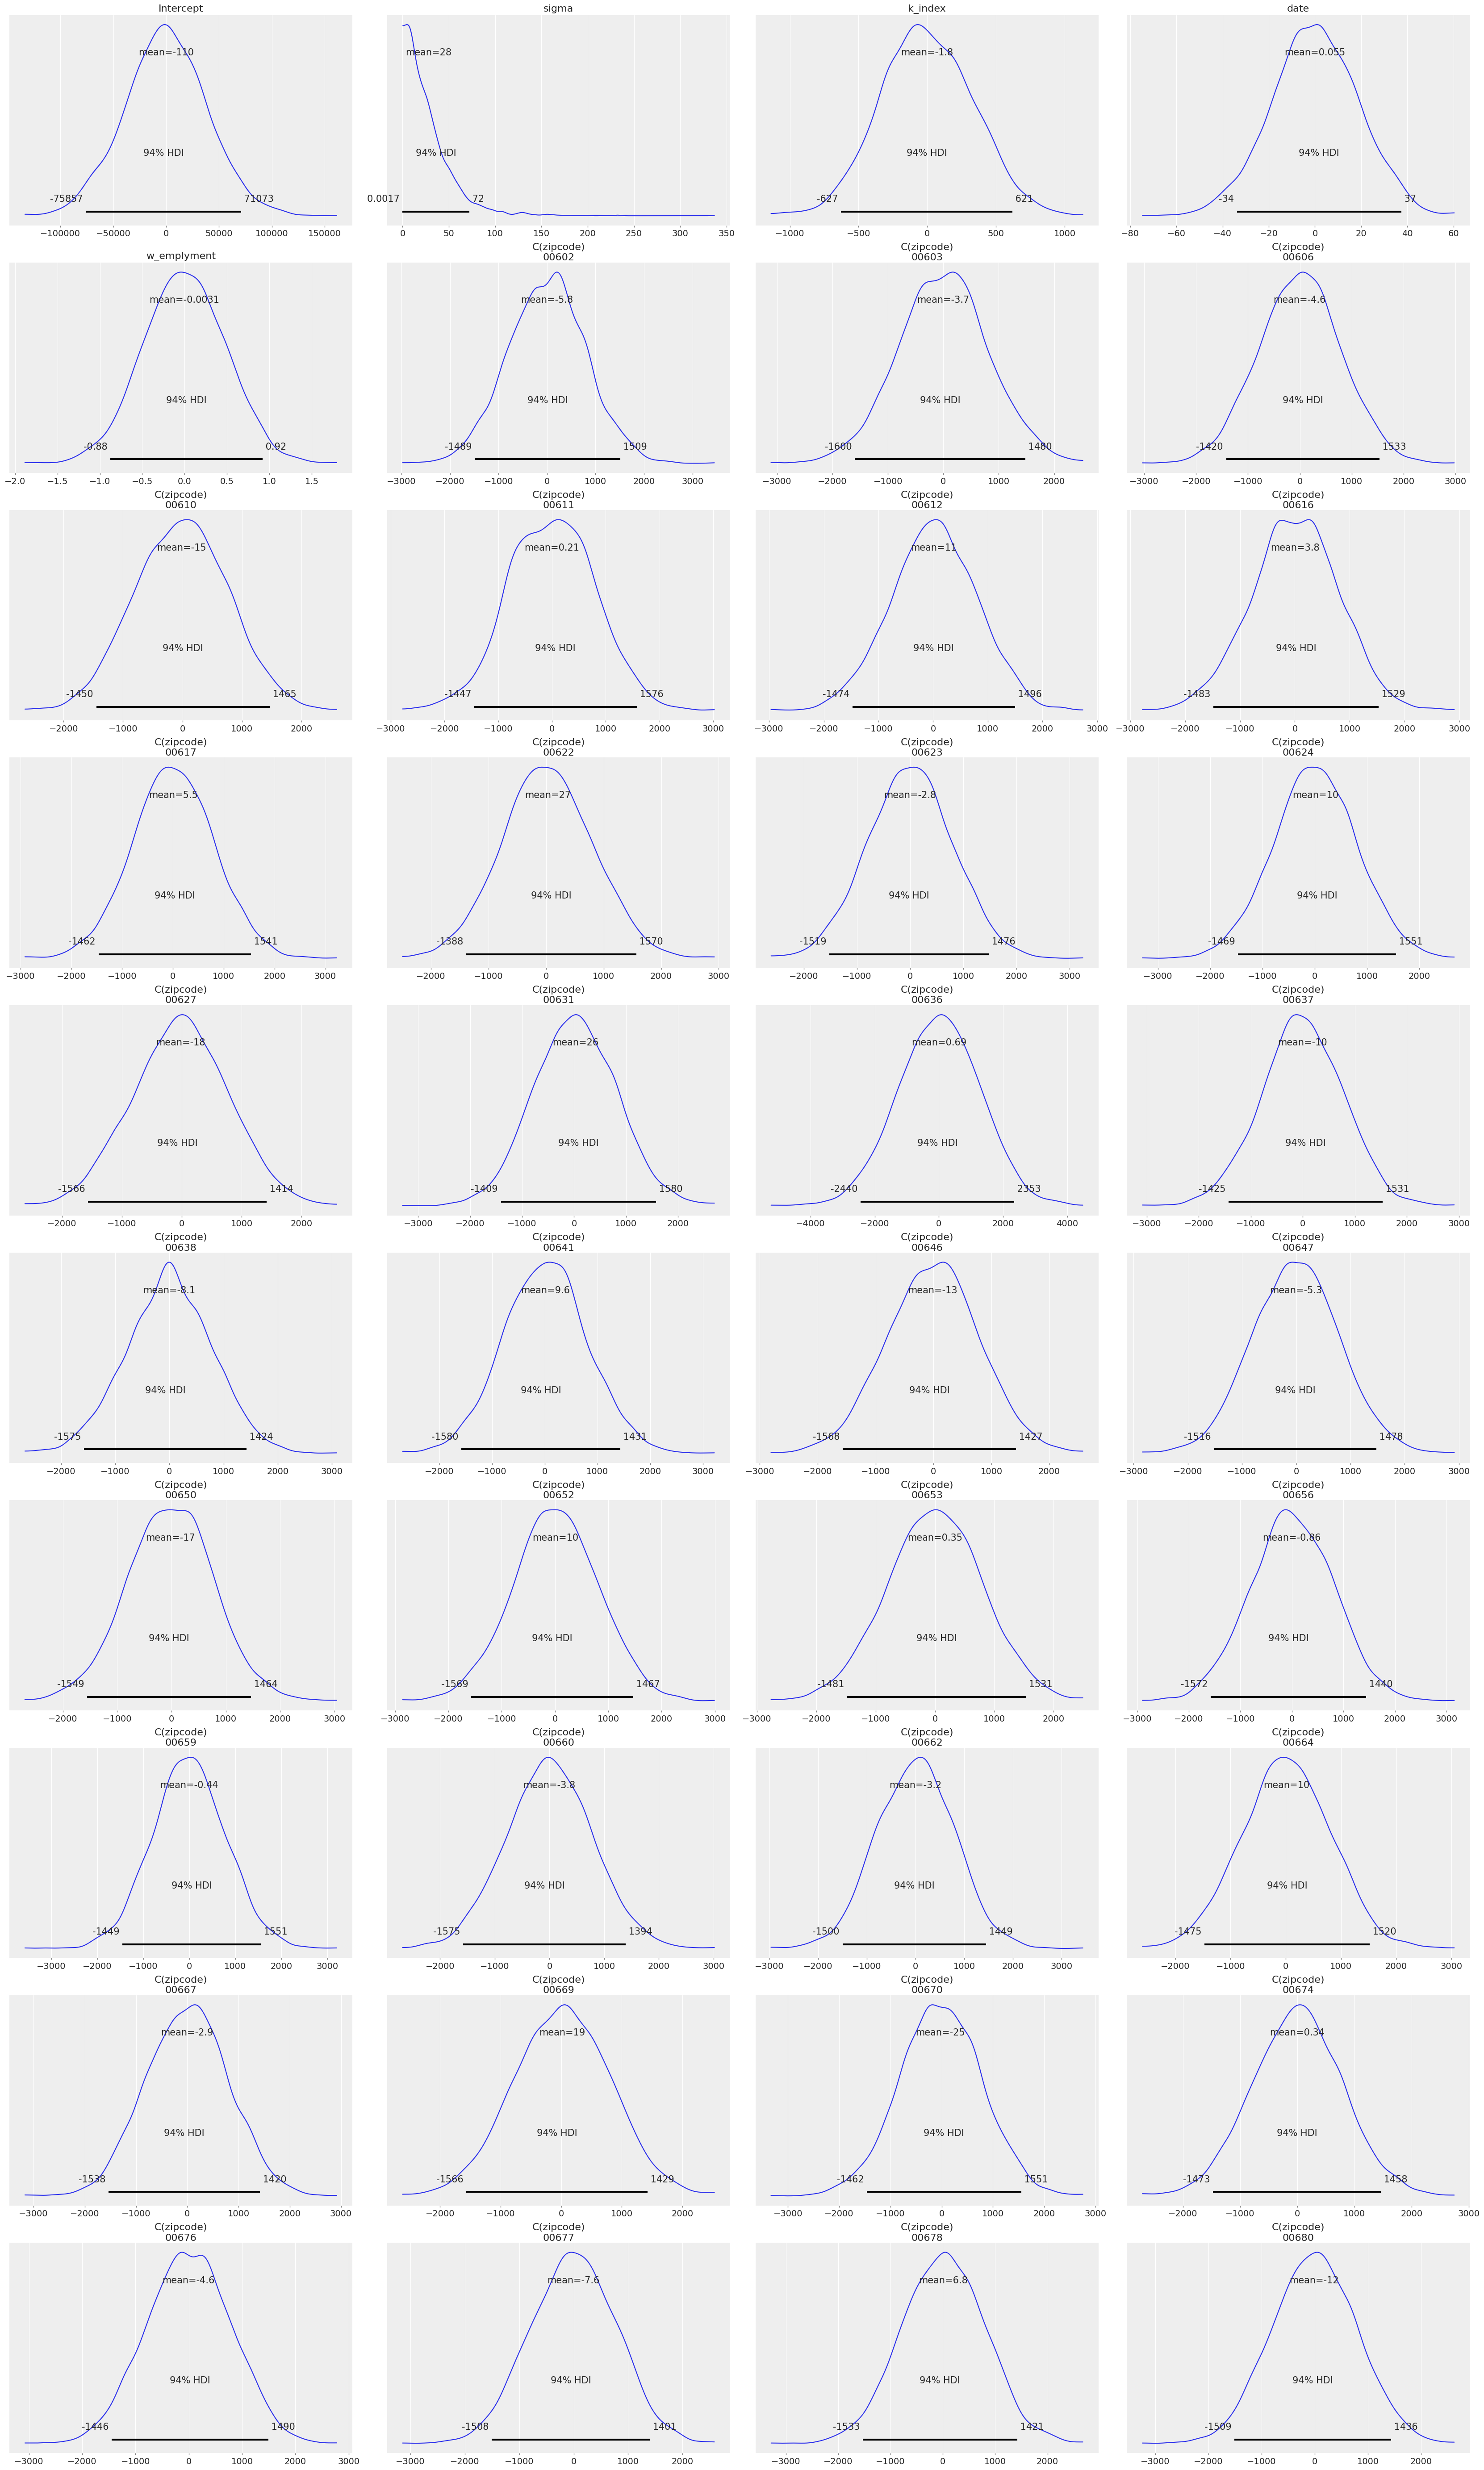

In [9]:
model.plot_priors()

array([[<Axes: title={'center': 'C(zipcode)'}>,
        <Axes: title={'center': 'C(zipcode)'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'date'}>],
       [<Axes: title={'center': 'inc_100k_150k'}>,
        <Axes: title={'center': 'inc_100k_150k'}>],
       [<Axes: title={'center': 'inc_10k_15k'}>,
        <Axes: title={'center': 'inc_10k_15k'}>],
       [<Axes: title={'center': 'inc_150k_200k'}>,
        <Axes: title={'center': 'inc_150k_200k'}>],
       [<Axes: title={'center': 'inc_15k_25k'}>,
        <Axes: title={'center': 'inc_15k_25k'}>],
       [<Axes: title={'center': 'inc_25k_35k'}>,
        <Axes: title={'center': 'inc_25k_35k'}>],
       [<Axes: title={'center': 'inc_35k_50k'}>,
        <Axes: title={'center': 'inc_35k_50k'}>],
       [<Axes: title={'center': 'inc_50k_75k'}>,
        <Axes: title={'center': 'inc_50k_75k'}>],
       [<Axes: title={

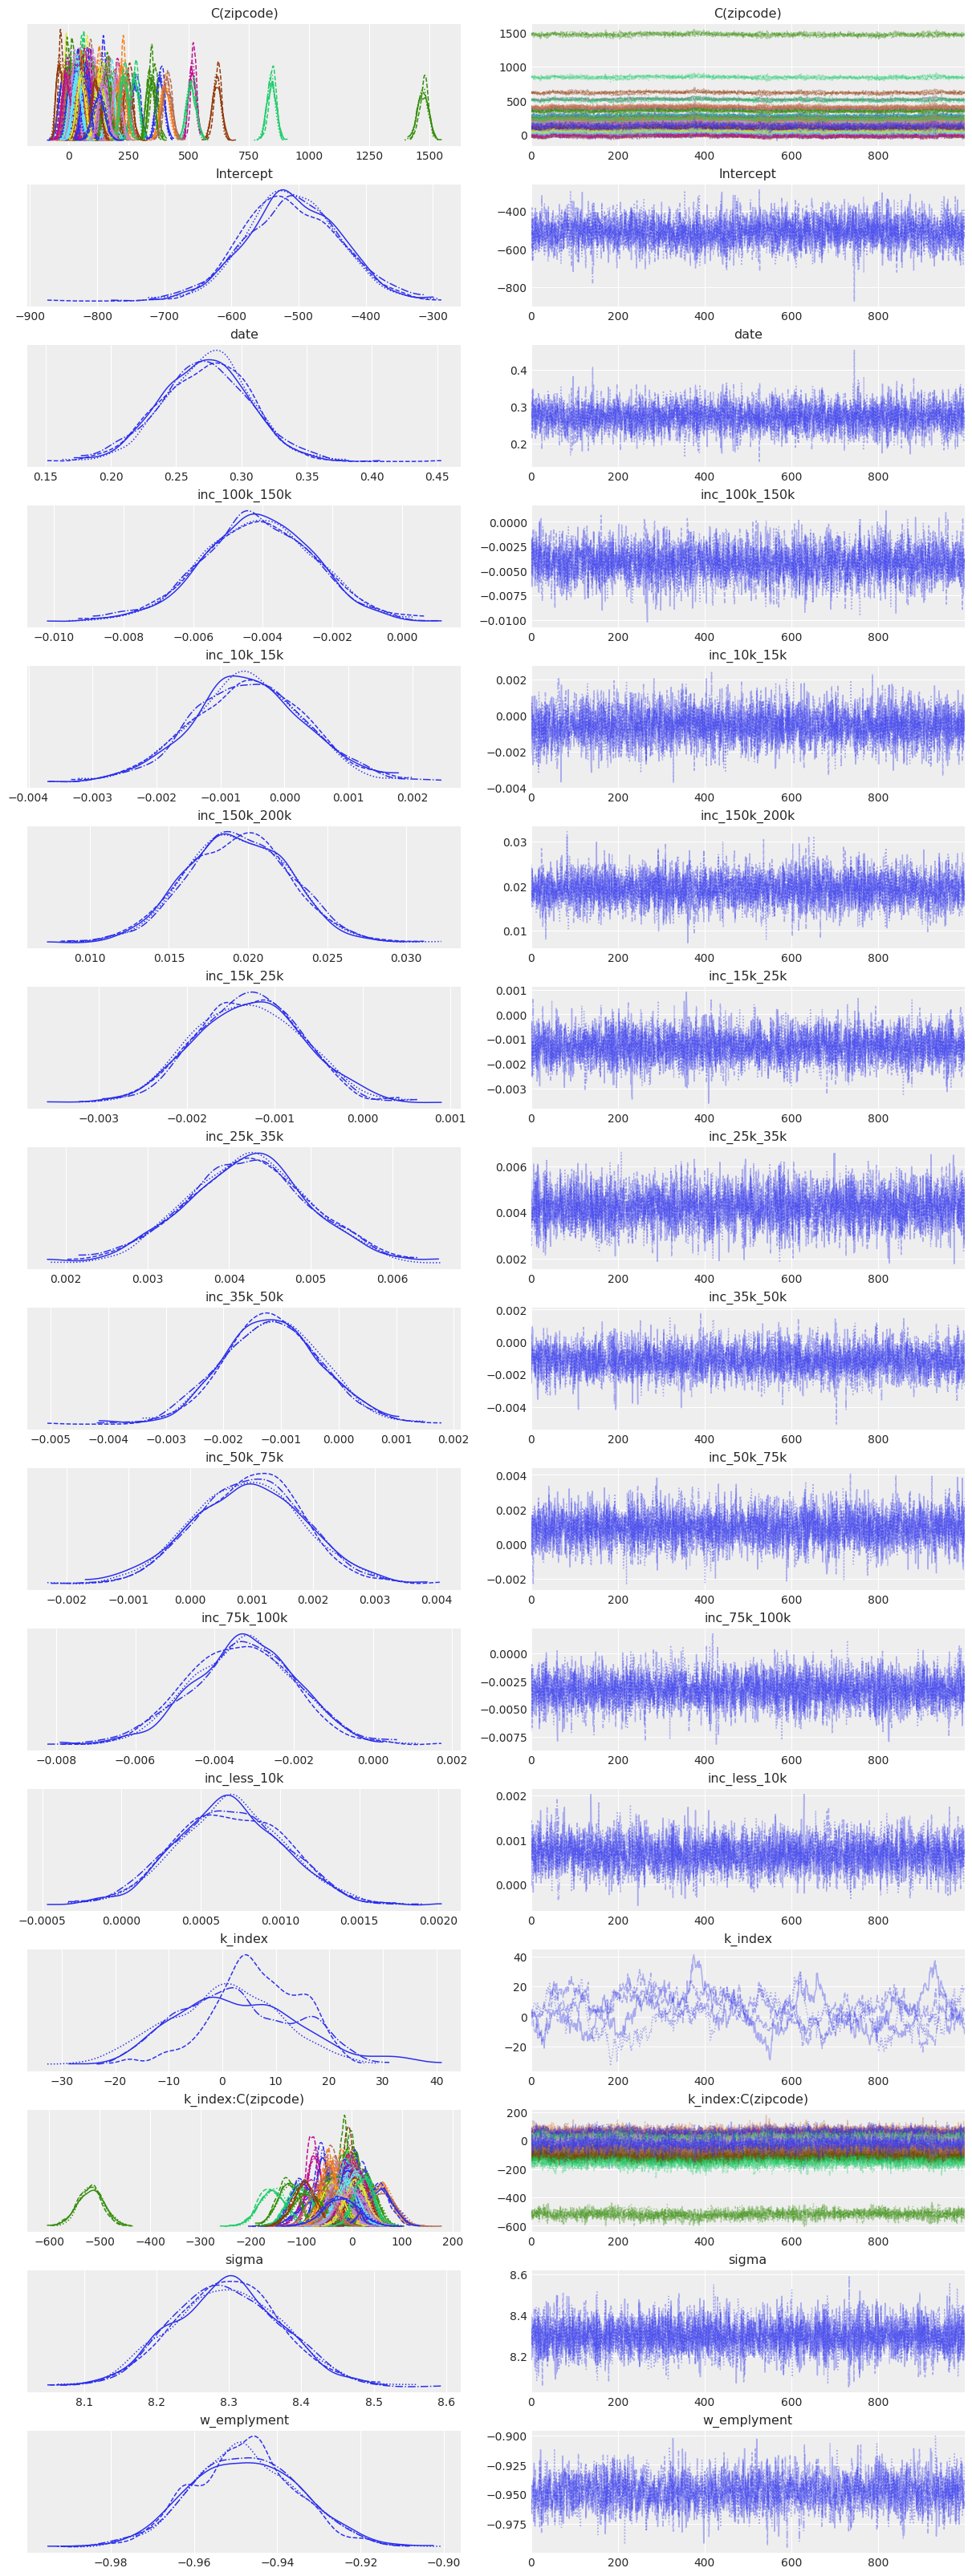

In [10]:
# Plot posteriors
az.plot_trace(
    results,
    compact=True,
)

In [14]:
res = az.summary(results)
res

mean      sd   hdi_3%  hdi_97%  mcse_mean  \
C(zipcode)[00602]          -20.805  18.031  -54.553   12.453      2.396   
C(zipcode)[00603]           59.345  16.562   28.716   90.058      2.310   
C(zipcode)[00606]          119.034  17.505   85.807  151.296      2.268   
C(zipcode)[00610]           72.840  17.491   39.514  103.313      2.176   
C(zipcode)[00611]          -34.797  13.060  -58.867  -11.156      2.391   
...                            ...     ...      ...      ...        ...   
k_index:C(zipcode)[00983]   -1.545  26.442  -50.471   49.030      1.592   
k_index:C(zipcode)[00985]  -61.108  22.494 -103.594  -20.109      1.486   
k_index:C(zipcode)[00987]  -21.967  34.255  -85.904   42.650      2.127   
sigma                        8.297   0.075    8.163    8.442      0.001   
w_emplyment                 -0.948   0.013   -0.970   -0.922      0.000   

                           mcse_sd  ess_bulk  ess_tail  r_hat  
C(zipcode)[00602]            0.564      57.0     465.0   1.06  
C(zipcode)[00603]            0.582      51.0     314.0   1.06  
C(zipcode)[00606]            0.500      60.0     409.0   1.06  
C(zipcode)[00610]            0.514      67.0     503.0   1.05  
C(zipcode)[00611]            0.703      30.0     173.0   1.11  
...                            ...       ...       ...    ...  
k_index:C(zipcode)[00983]    0.447     283.0    1008.0   1.02  
k_index:C(zipcode)[00985]    0.394     228.0    1109.0   1.02  
k_index:C(zipcode)[00987]    0.555     260.0    1649.0   1.02  
sigma                        0.001    5673.0    2837.0   1.00  
w_emplyment                  0.000    2569.0    2826.0   1.00  

[276 rows x 9 columns]

In [12]:
res.to_csv("test.csv")

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

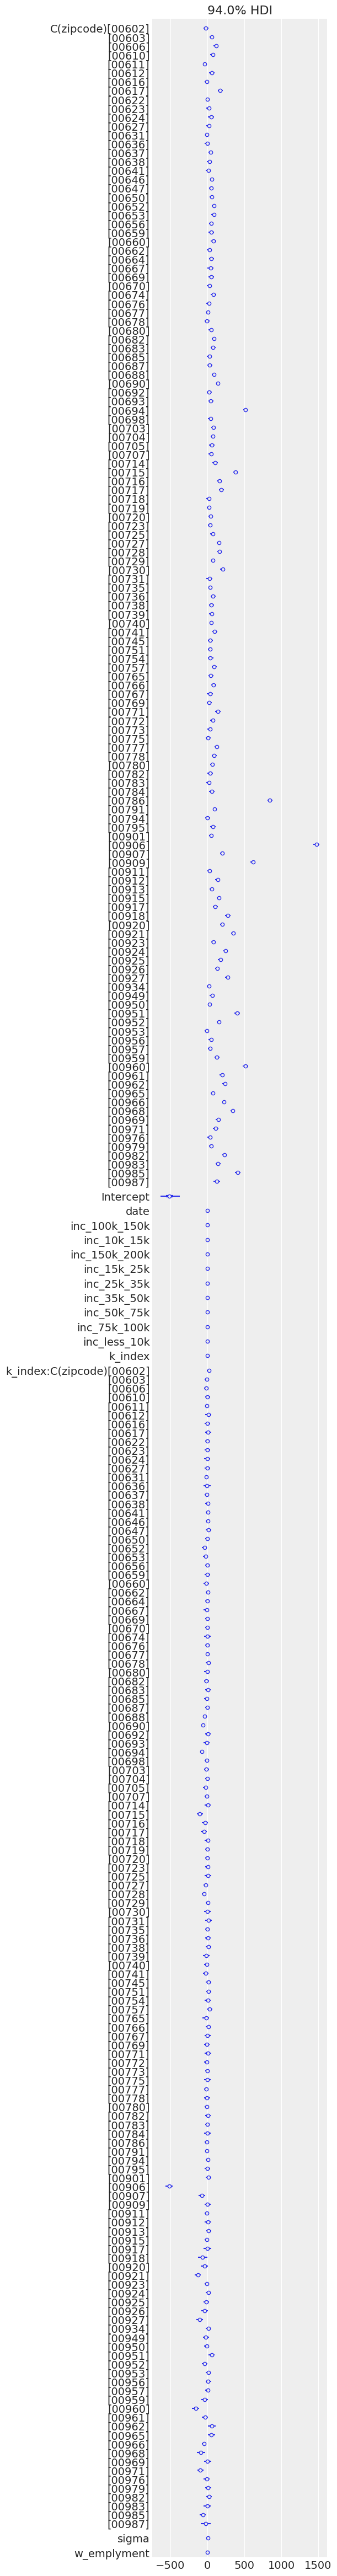

In [20]:
az.plot_forest(results, combined=True, hdi_prob=0.94)

In [19]:
rows_to_extract = [
        'inc_25k_35k', 'inc_35k_50k', 'inc_50k_75k',
    'inc_75k_100k', 'inc_100k_150k', 'inc_150k_200k',
    "Intercept",
    "date",
    "k_index",
    "sigma",
    "w_emplyment"
]

# Extract rows by index
res.loc[rows_to_extract]

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
inc_25k_35k      0.004   0.001    0.003    0.006      0.000    0.000   
inc_35k_50k     -0.001   0.001   -0.003    0.000      0.000    0.000   
inc_50k_75k      0.001   0.001   -0.001    0.003      0.000    0.000   
inc_75k_100k    -0.003   0.001   -0.006   -0.001      0.000    0.000   
inc_100k_150k   -0.004   0.002   -0.007   -0.001      0.000    0.000   
inc_150k_200k    0.019   0.003    0.013    0.025      0.000    0.000   
Intercept     -509.406  69.552 -635.038 -374.716      1.536    1.015   
date             0.273   0.034    0.209    0.336      0.000    0.001   
k_index          3.308  10.852  -17.529   21.807      2.002    0.632   
sigma            8.297   0.075    8.163    8.442      0.001    0.001   
w_emplyment     -0.948   0.013   -0.970   -0.922      0.000    0.000   

               ess_bulk  ess_tail  r_hat  
inc_25k_35k      5068.0    3070.0   1.00  
inc_35k_50k      4213.0    3242.0   1.00  
inc_50k_75k      5011.0    3327.0   1.00  
inc_75k_100k     5101.0    3001.0   1.00  
inc_100k_150k    4306.0    3395.0   1.00  
inc_150k_200k    4495.0    3305.0   1.00  
Intercept        2041.0    3081.0   1.00  
date             4625.0    2912.0   1.00  
k_index            29.0     155.0   1.12  
sigma            5673.0    2837.0   1.00  
w_emplyment      2569.0    2826.0   1.00